<a href="https://colab.research.google.com/github/biniyam-mulugeta/final/blob/main/ROC_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np

# Load data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Reshape and normalize data
x_train = x_train.reshape(-1, 28, 28, 1) / 255.0
x_test = x_test.reshape(-1, 28, 28, 1) / 255.0

In [14]:
# Define CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train model
model.fit(x_train, y_train, epochs=3, validation_data=(x_test, y_test))


Epoch 1/3
1875/1875 [==============================] - 12s 5ms/step - loss: 0.5576 - accuracy: 0.7949 - val_loss: 0.4317 - val_accuracy: 0.8399
Epoch 2/3
1875/1875 [==============================] - 10s 6ms/step - loss: 0.3745 - accuracy: 0.8617 - val_loss: 0.3563 - val_accuracy: 0.8686
Epoch 3/3
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3153 - accuracy: 0.8828 - val_loss: 0.3487 - val_accuracy: 0.8749


In [15]:
# Get CNN predictions on test set
cnn_probs = model.predict(x_test)
cnn_preds = np.argmax(cnn_probs, axis=1)

# Flatten CNN output for SVM input
cnn_output = model.layers[-2].output
flatten_layer = tf.keras.layers.Flatten()(cnn_output)
svm_input = tf.keras.backend.function([model.input], [flatten_layer])(x_test)

# Train SVM classifier
svm = SVC(kernel='linear')
svm.fit(svm_input[0], y_test)

# Get SVM predictions on test set
svm_preds = svm.predict(svm_input[0])

# Evaluate accuracy
cnn_acc = accuracy_score(y_test, cnn_preds)
svm_acc = accuracy_score(y_test, svm_preds)
print("CNN accuracy:", cnn_acc)
print("SVM accuracy:", svm_acc)

313/313 [==============================] - 1s 2ms/step
CNN accuracy: 0.8749
SVM accuracy: 0.9138


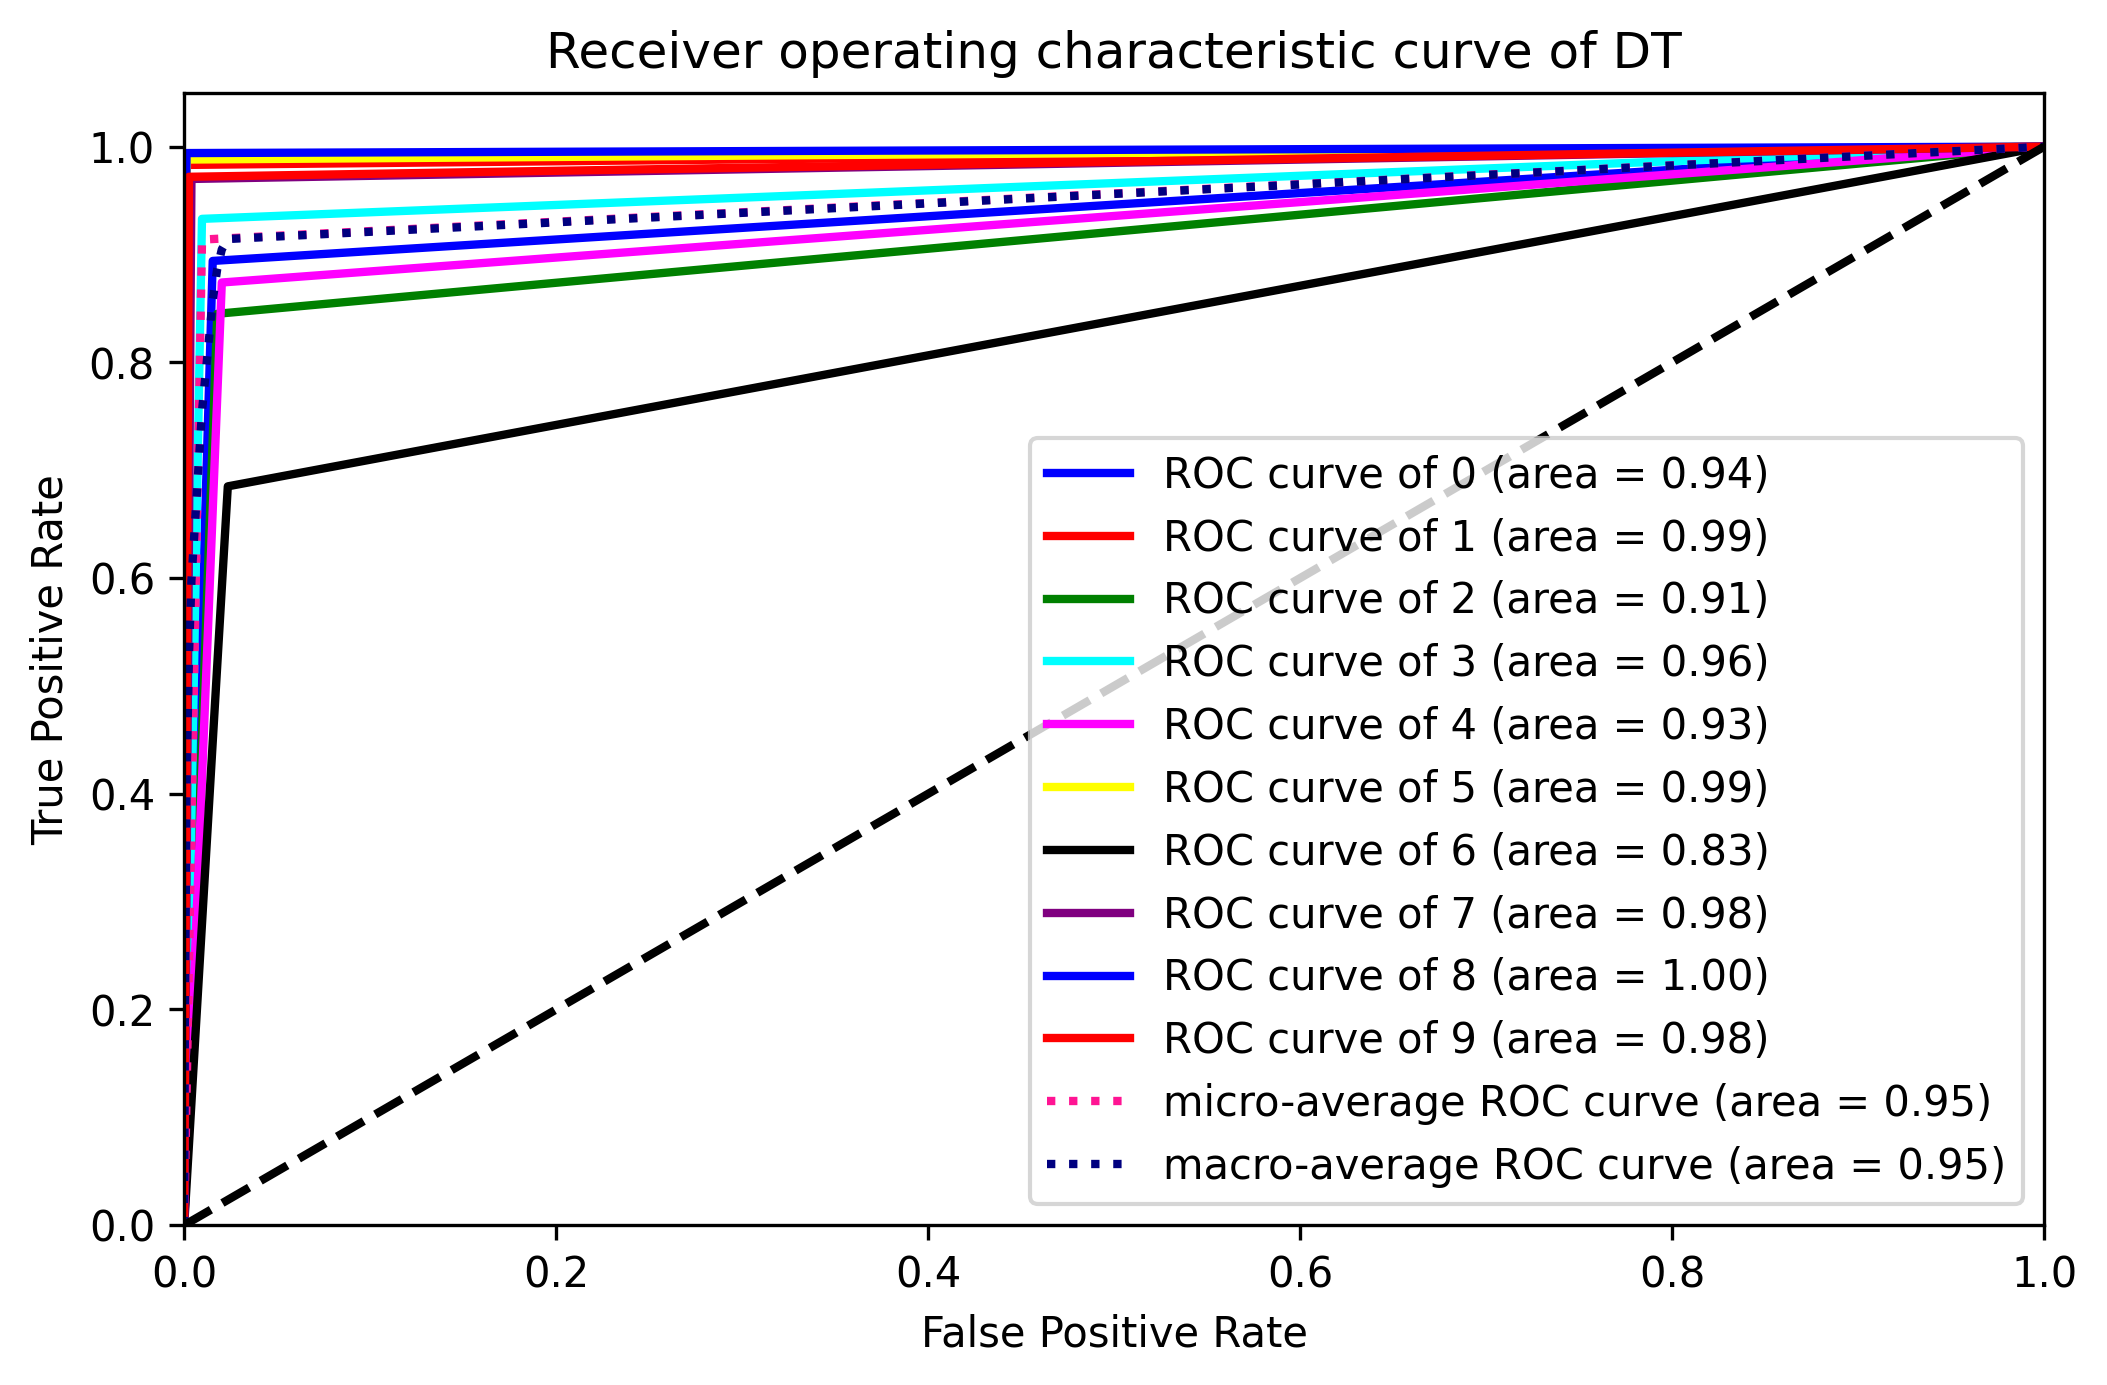

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Define class names
class_names = labeles = ['0','1','2','3','4','5','6','7','8','9']

# Define number of classes
num_classes = len(class_names)

# Generate some example data
#y_true = np.array([0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7])
#y_score = np.random.rand(16, num_classes)  # Replace with your own prediction scores

# Binarize the labels
y_true = label_binarize(y_test, classes=np.arange(num_classes))
y_pre = label_binarize(svm_preds, classes=np.arange(num_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pre[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pre.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC curve
plt.figure(figsize=(8,5),dpi=300)
lw = 2
colors = cycle(['blue', 'red', 'green', 'cyan', 'magenta', 'yellow', 'black', 'purple'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='ROC curve of {0} (area = {1:0.2f})'
             ''.format(class_names[i], roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"], color='deeppink', lw=lw, linestyle=':', label='micro-average ROC curve (area = {0:0.2f})'
             ''.format(roc_auc["micro"]))

plt.plot(fpr["macro"], tpr["macro"], color='navy', lw=lw, linestyle=':', label='macro-average ROC curve (area = {0:0.2f})'
             ''.format(roc_auc["macro"]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve of DT')
plt.legend(loc="lower right")
plt.show()
